# Capstone Project - The Battle of Neighbourhoods

In [ ]:
# install any required packages

!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes
print('packages installed')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\jjwgo\Anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.7.12               |           py37_0         3.0 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.20.0-py_0

The following packages will be UPDATED:

  conda                      pkgs/main::conda-4.7.10-py37_0 --> conda-forge::conda-4.7.12-py37_0




geopy-1.20.0         | 57 K



==> WARNING: A newer version of conda exists. <==
  current version: 4.7.10
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda




In [ ]:
# import required libraries

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests
from bs4 import BeautifulSoup as bs
import lxml
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium # map rendering library
from folium import IFrame
from folium.features import DivIcon
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import DBSCAN 
import sklearn.utils
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics

print('import complete')

In [3]:
#Obtain a list of neighbourhood names and associated postcodes from https://en.wikipedia.org/wiki/G_postcode_area

url = 'https://en.wikipedia.org/wiki/G_postcode_area'          # define the URL
raw_wiki = requests.get(url).text          #retrieve the raw wikipedia page and convert to text
soup = bs(raw_wiki, 'lxml')          #feed into beautifulsoup

#parse the table into a list
cells = []
table = soup.find('table', class_='wikitable sortable')          #there is only one instance of 'wikitable sortable' just before the table of postcodes
table_body = table.find('tbody')          # find the start of the table
rows = table_body.find_all('tr')          # find the number of rows in the table
for row in rows:          # for each row
    cols = row.find_all('th')
    cols = [ele.text.strip() for ele in cols]          # strip the details from th cells in the row
    cols1 = row.find_all('td')
    cols1 = [ele.text.strip() for ele in cols1]          # strip the deatils from td cells in the row
    cols2 = cols + cols1          # merge into a single entry
    cells.append(cols2)          # add them to the list and get rid of empty values
data = pd.DataFrame(cells, columns=['Postcode', 'Post Town', 'Neighborhood', 'Authority'])          # convert the list to a dataframe
data = data.drop([0]).reset_index(drop=True)          # drop the unrequired first row (due to th was just col headers again)
data = data.drop(['Post Town', 'Authority'], axis=1)          # drop the unrequired columns
data = data[~data['Neighborhood'].str.contains('Non-geographic')].reset_index(drop=True)          # drop any row where Neighbourhood starts with 'Non-geographic'

# clean up the Neighbourhood cells so it is just the names (remove 'Former XX district: ')
data['Indexes']= data['Neighborhood'].str.find(': ', 1)          # find the location of ':' in cell (if present)
temp = []          # temp var to hold the sliced cell entries
for i in range(0, len(data)):          # check each row
    if data.iloc[i]['Indexes'] != -1:          # only slice if there was a ':'
        start = data.iloc[i]['Indexes'] + 2
        temp.append(data.iloc[i]['Neighborhood'][start:])
    else:
        temp.append(data.iloc[i]['Neighborhood'])
data['Neighbourhood'] = temp          # add to new column in dataframe
data = data.drop(['Neighborhood', 'Indexes'], axis=1)          # remove the un-necessary columns

# remove rows for outlying neighbourhoods
remove = ['G60', 'G61', 'G62', 'G63', 'G64', 'G65', 'G66', 'G67', 'G68', 'G69', 'G71', 'G72', 'G74', 'G75', 'G76', 'G77', 'G78', 'G81', 'G82', 'G83', 'G84']
data = data[~data['Postcode'].isin(remove)].reset_index(drop=True)          
print(data.shape)
data.head()
#data

(29, 2)


,Postcode,Neighbourhood
0,G1,Merchant City
1,G2,"Blythswood Hill, Anderston (part)"
2,G3,"Anderston, Finnieston, Garnethill, Park, Woodl..."
3,G4,"Calton (part), Cowcaddens (part), Drygate, Kel..."
4,G5,Gorbals


In [4]:
# Obtain Latitudes and Longitudes for each postcode, glasgow_postcodes.csv uploaded to notebook folder

postcodes = pd.read_csv('glasgow_postcodes.csv')          # store in dataframe
neighbourhoods = pd.merge(data, postcodes, on= 'Postcode')          # merge data and postcode dataframes
print(neighbourhoods.shape)
neighbourhoods.head()

(29, 4)


,Postcode,Neighbourhood,Latitude,Longitude
0,G1,Merchant City,55.8586,-4.2456
1,G2,"Blythswood Hill, Anderston (part)",55.8636,-4.2612
2,G3,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.2780
3,G4,"Calton (part), Cowcaddens (part), Drygate, Kel...",55.8710,-4.2494
4,G5,Gorbals,55.8433,-4.2450


In [5]:
# Create a map of the neighbourhoods
address = 'Glasgow'          # get starting latitude and longitude for Glasgow
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates are {}, {}.'.format(latitude, longitude))

# create map using latitude and longitude values
neighbourhoodmap = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, neighbourhood in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Neighbourhood']):
    label = neighbourhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(neighbourhoodmap)  
    
neighbourhoodmap

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinates are 55.856656, -4.2435817.


In [6]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'hidden'          # Foursquare ID
CLIENT_SECRET = 'hidden'          # Foursquare Secret
VERSION = '20180605'          # Foursquare API version
# uncomment before upload

In [7]:
# Define function to get x venues within y radius of each neighbourhood
def getVenues(names, latitudes, longitudes):
#    venues_list=[]
    venues_list = pd.DataFrame()
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # Define the corresponding URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            VERSION, 
            search_query, 
            radius, 
            LIMIT)
        # Send the GET Request
        results = requests.get(url).json()
        # assign relevant part of JSON to venues
        venues = results['response']['venues']
        # tranform venues into a dataframe
        venues_df = json_normalize(venues)
        # check results have been returned for neighbourhood
        if 'name' in venues_df.columns:
            #create 2nd dataframe with neighbourhood name, latitude and longitude for same length
            neigh_df = pd.DataFrame(index = range(0, len(venues_df)), columns = ['Neighbourhood', 'Latitude', 'Longitude'])
            neigh_df['Neighbourhood'] = name
            neigh_df['Latitude'] = lat
            neigh_df['Longitude'] = lng
            # keep only columns that include venue name, and anything that is associated with location
            required_cols = ['name', 'categories', 'location.lat', 'location.lng']
            filtered_df = venues_df.loc[:, required_cols]
            # function that extracts the category of the venue
            def get_cat_type(row):
                try:
                    cat_list = row['categories']
                except:
                    cat_list = row['venue.categories']
            
                if len(cat_list) == 0:
                    return None
                else:
                    return cat_list[0]['name']
            # filter the category for each row
            filtered_df['categories'] = filtered_df.apply(get_cat_type, axis=1)
        else:
            #create 2nd dataframe with neighbourhood name, latitude and longitude for same length
            neigh_df = pd.DataFrame(columns = ['Neighbourhood', 'Latitude', 'Longitude'])
            neigh_df.loc[0] = [name, lat, lng]
            # create a single row dataframe with correct column names but 'none' as the values
            filtered_df = pd.DataFrame([['none', 'none', 0, 0]], columns=list('ABCD'))
        # clean column names
        filtered_df.columns = ['Venue_Name', 'Venue_Cat', 'Venue_Lat', 'Venue_Lng']

        # merge two neighbourhood and venue dataframes
        joined_df = neigh_df.join(filtered_df, how = 'outer')

        venues_list = venues_list.append(joined_df).reset_index(drop=True)
    return(venues_list)

In [8]:
# define a query to search for specified venue type within specified metres
search_query = 'Coffee'
radius = 1500
LIMIT = 10000

# Call function
VenuesList1 = getVenues(names=neighbourhoods['Neighbourhood'],
                                   latitudes=neighbourhoods['Latitude'],
                                   longitudes=neighbourhoods['Longitude']
                                  )
print(VenuesList1.shape)

Merchant City
Blythswood Hill, Anderston (part)
Anderston, Finnieston, Garnethill, Park, Woodlands (part), Yorkhill
Calton (part), Cowcaddens (part), Drygate, Kelvinbridge, Townhead, Woodlands (part), Woodside (part)
Gorbals
Broomhill, Partick, Partickhill
West End (part), Cleveden, Dowanhill, Hillhead, Hyndland, Kelvindale, Botanic Gardens, University of Glasgow
Anniesland, Knightswood, Yoker
Whiteinch, Scotstoun
Drumchapel
Maryhill, North Kelvinside, Ruchill
Balornock, Barmulloch, Cowlairs, Royston, Springburn, Sighthill
Milton, Parkhouse, Possilpark
Lambhill, Summerston
Dennistoun, Haghill, Parkhead (part)
Carmyle, Tollcross, Mount Vernon, Lightburn, Sandyhills, Shettleston, Springboig
Cardowan, Carntyne, Craigend, Cranhill, Garthamlock, Millerston, Provanmill, Queenslie, Riddrie, Robroyston, Ruchazie, Stepps, Wellhouse
Easterhouse, Easthall, Provanhall
Bridgeton, Calton, Dalmarnock
Pollokshields, Shawlands
Battlefield, Govanhill, Mount Florida, Strathbungo (part), Toryglen
Mansewoo

In [9]:
# define a query to search for specified venue type within specified metres
search_query = 'Restaurant'
radius = 750
LIMIT = 1000

# Call function
VenuesList2 = getVenues(names=neighbourhoods['Neighbourhood'],
                                   latitudes=neighbourhoods['Latitude'],
                                   longitudes=neighbourhoods['Longitude']
                                  )
print(VenuesList2.shape)

Merchant City
Blythswood Hill, Anderston (part)
Anderston, Finnieston, Garnethill, Park, Woodlands (part), Yorkhill
Calton (part), Cowcaddens (part), Drygate, Kelvinbridge, Townhead, Woodlands (part), Woodside (part)
Gorbals
Broomhill, Partick, Partickhill
West End (part), Cleveden, Dowanhill, Hillhead, Hyndland, Kelvindale, Botanic Gardens, University of Glasgow
Anniesland, Knightswood, Yoker
Whiteinch, Scotstoun
Drumchapel
Maryhill, North Kelvinside, Ruchill
Balornock, Barmulloch, Cowlairs, Royston, Springburn, Sighthill
Milton, Parkhouse, Possilpark
Lambhill, Summerston
Dennistoun, Haghill, Parkhead (part)
Carmyle, Tollcross, Mount Vernon, Lightburn, Sandyhills, Shettleston, Springboig
Cardowan, Carntyne, Craigend, Cranhill, Garthamlock, Millerston, Provanmill, Queenslie, Riddrie, Robroyston, Ruchazie, Stepps, Wellhouse
Easterhouse, Easthall, Provanhall
Bridgeton, Calton, Dalmarnock
Pollokshields, Shawlands
Battlefield, Govanhill, Mount Florida, Strathbungo (part), Toryglen
Mansewoo

In [10]:
frames = [VenuesList1, VenuesList2]

VenuesList = pd.concat(frames)
VenuesList.to_csv('glasgow_venues.csv')          #comment out once testing complete
VenuesList.sort_values('Neighbourhood', inplace=True)
VenuesList.head()

,Neighbourhood,Latitude,Longitude,Venue_Name,Venue_Cat,Venue_Lat,Venue_Lng
112,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,Costa Coffee,Coffee Shop,55.863247,-4.253007
65,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,The Mariner Restaurant,Hotel,55.858700,-4.283970
64,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,Marcellos Restaurant,Restaurant,55.865394,-4.268078
63,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,Loon Fung Cantonese Restaurant,Chinese Restaurant,55.865716,-4.268138
62,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,U Jarka Restaurant,Eastern European Restaurant,55.867373,-4.284590


In [13]:
# During testing a CSV of VenuesList dataframe was created so as not to have to call foursquare multiple times
#VenuesList = pd.read_csv('glasgow_venues.csv')
#VenuesList = VenuesList.drop(VenuesList.columns[0], axis = 1)
#VenuesList[['Venue_Lat', 'Venue_Lng']] = VenuesList[['Venue_Lat', 'Venue_Lng']].astype('float')
#print(VenuesList.shape)
#VenuesList.sort_values('Neighbourhood', inplace=True)
#VenuesList.head()
# comment out once testing complete
VenuesList.shape

(434, 7)

In [11]:
# Create a map of the venues

# create map using latitude and longitude values
venuemap = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, venue in zip(VenuesList['Venue_Lat'], VenuesList['Venue_Lng'], VenuesList['Venue_Name']):
    label = venue
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(venuemap)  
    
venuemap

In [14]:
# Get counts of venues by neighbourhood
temp = VenuesList[~VenuesList['Venue_Name'].str.contains('none')].reset_index(drop=True)
value_counts = temp['Neighbourhood'].value_counts(dropna=True, sort=True)
temp = value_counts.rename_axis('Neighbourhood').reset_index(name='Counts')

results = pd.merge(neighbourhoods, temp, how='left', on='Neighbourhood')
results.fillna(0, inplace=True)

results.sort_values('Counts', ascending=False, inplace=True)
results

,Postcode,Neighbourhood,Latitude,Longitude,Counts
1,G2,"Blythswood Hill, Anderston (part)",55.8636,-4.2612,82.0
0,G1,Merchant City,55.8586,-4.2456,73.0
2,G3,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.2780,68.0
3,G4,"Calton (part), Cowcaddens (part), Drygate, Kel...",55.8710,-4.2494,56.0
5,G11,"Broomhill, Partick, Partickhill",55.8742,-4.3166,24.0
6,G12,"West End (part), Cleveden, Dowanhill, Hillhead...",55.8803,-4.3028,23.0
4,G5,Gorbals,55.8433,-4.2450,15.0
19,G41,"Pollokshields, Shawlands",55.8417,-4.2891,10.0
20,G42,"Battlefield, Govanhill, Mount Florida, Strathb...",55.8319,-4.2506,9.0
18,G40,"Bridgeton, Calton, Dalmarnock",55.8443,-4.2156,9.0


In [15]:
#emphasise neighbourhoods that have results to differentiate from those that have none
results['emphasis'] = results['Counts'].apply(lambda x: 0 if x==0 else x+20)

choromap = folium.Map(location=[latitude, longitude], zoom_start=12)         # create map
 
chorogeo = r'PostalDistricts1.json' # geojson file

# create a numpy array of length 6 and has linear spacing from the minium to the maximum
threshold_scale = np.linspace(results['emphasis'].min(),
                              results['emphasis'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum

# generate choropleth map
choromap.choropleth(
    geo_data=chorogeo,
    data=results,
    columns=['Postcode', 'emphasis'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Venue Count'
)

for lat, lon, poi in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Postcode']):
    text = poi
    folium.map.Marker(
        [lat, lon],
        icon=DivIcon(
            icon_size=(100,22),
            icon_anchor=(0,0),
            html='<div style="font-size: 16pt">%s</div>' % text,
            )
        ).add_to(choromap)
    
# display map
choromap

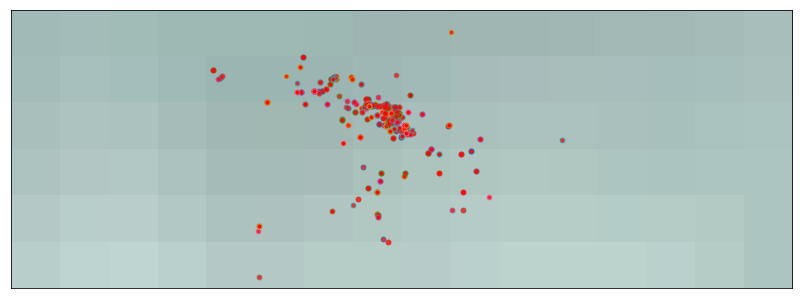

In [16]:
rcParams['figure.figsize'] = (14,10)

llon=-4.5
ulon=-4.0
llat=55.8
ulat=55.9

VenuesList = VenuesList[(VenuesList['Venue_Lng'] > llon) & (VenuesList['Venue_Lng'] < ulon) & (VenuesList['Venue_Lat'] > llat) &(VenuesList['Venue_Lat'] < ulat)]

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0,
            llcrnrlon=llon, llcrnrlat=llat, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon=ulon, urcrnrlat=ulat) #max longitude (urcrnrlon) and latitude (urcrnrlat)

my_map.drawcoastlines()
my_map.drawcountries()
# my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on locations        
xs,ys = my_map(np.asarray(VenuesList.Venue_Lng), np.asarray(VenuesList.Venue_Lat))
VenuesList['xm']= xs.tolist()
VenuesList['ym'] =ys.tolist()

#Visualization1
for index,row in VenuesList.iterrows():
#   x,y = my_map(row.Long, row.Lat)
   my_map.plot(row.xm, row.ym,markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)
#plt.text(x,y,stn)
plt.show()

In [36]:
sklearn.utils.check_random_state(1000)
Clus_dataSet = VenuesList[['xm','ym']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=7).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
VenuesList["Clus_Db"]=labels

# Number of clusters in labels, ignoring noise if present.
realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

print('Estimated number of clusters: %d' % realClusterNum)
print('Estimated number of noise points: %d' % clusterNum)

# A sample of clusters
VenuesList.head()

Estimated number of clusters: 7
Estimated number of noise points: 8


,Neighbourhood,Latitude,Longitude,Venue_Name,Venue_Cat,Venue_Lat,Venue_Lng,xm,ym,Clus_Db
112,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,Costa Coffee,Coffee Shop,55.863247,-4.253007,27464.319161,12522.104740,0
65,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,The Mariner Restaurant,Hotel,55.858700,-4.283970,24021.435030,11621.166152,-1
64,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,Marcellos Restaurant,Restaurant,55.865394,-4.268078,25788.514208,12947.437851,1
63,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,Loon Fung Cantonese Restaurant,Chinese Restaurant,55.865716,-4.268138,25781.813160,13011.342352,1
62,"Anderston, Finnieston, Garnethill, Park, Woodl...",55.8644,-4.278,U Jarka Restaurant,Eastern European Restaurant,55.867373,-4.284590,23952.542104,13339.763803,-1


In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i+x+(i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(VenuesList['Venue_Lat'], VenuesList['Venue_Lng'], VenuesList['Venue_Name'], VenuesList['Clus_Db']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [38]:

finalmap = folium.Map(location=[latitude, longitude], zoom_start=13)         # create map

for lat, lon, poi in zip(neighbourhoods['Latitude'], neighbourhoods['Longitude'], neighbourhoods['Postcode']):
    text = poi
    folium.map.Marker(
        [lat, lon],
        icon=DivIcon(
            icon_size=(100,22),
            icon_anchor=(0,0),
            html='<div style="font-size: 18pt">%s</div>' % text,
            )
        ).add_to(finalmap)
    
chorogeo = r'PostalDistricts1.json' # geojson file

# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(results['emphasis'].min(),
                              results['emphasis'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration

# generate choropleth map
finalmap.choropleth(
    geo_data=chorogeo,
    data=results,
    columns=['Postcode', 'emphasis'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='PuBuGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Venue Count'
)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i+x+(i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(VenuesList['Venue_Lat'], VenuesList['Venue_Lng'], VenuesList['Venue_Name'], VenuesList['Clus_Db']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(finalmap)

# display map
finalmap